In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import needed instruments
from tensorflow.keras.models import Model , load_model

from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

from tensorflow.keras.optimizers import Adam

from tensorflow.keras import utils

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image

import numpy as np

import time, random, gdown, os

from PIL import Image, ImageOps, ImageEnhance

from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set_style('darkgrid')

# Load data

In [ ]:
!unzip -qo /content/gdrive/MyDrive/Colab_Notebooks/Diplom/data_all/x.zip  # Unpacking folder with original train photos

In [ ]:
!unzip -qo /content/gdrive/MyDrive/Colab_Notebooks/Diplom/data_all/y.zip  # Unpacking folder with segmented train photos

# Parameters

In [ ]:
way = (255,255,255)  # Color of the road
backg = (0,0,0)      # Color of the background

class_labels = (way, backg)   # List of classes

In [ ]:
# Image size used in training process
img_h = 60
img_w = 80

# Functions for preparing the data

In [ ]:
def load_imageset(folder: str) -> list:
    """
    Load images from a 'folder'
    """

    image_list = []
    cur_time = time.time()
    for filename in sorted(os.listdir(folder)):
        image_list.append(image.load_img(os.path.join(folder, filename), target_size=(img_h, img_w)))

    print('All imageset is loaded. Time of loading: {:.2f} с'.format( time.time() - cur_time))
    print('Number of pictures:', len(image_list))

    return image_list

In [ ]:
def show_imageset(image_list: list, n: int) -> None:
    """
    Show 'n' qty of image_list.
    """

    fig, axs = plt.subplots(1, n, figsize=(25, 10))

    for i in range(n):
        img = random.choice(image_list)
        axs[i].axis('off')
        axs[i].imshow(img)

    plt.show()

In [ ]:
all_images = load_imageset('x')

all_segments = load_imageset('y')

All imageset is loaded. Time of loading: 0.76 с
Number of pictures: 400
All imageset is loaded. Time of loading: 0.34 с
Number of pictures: 400


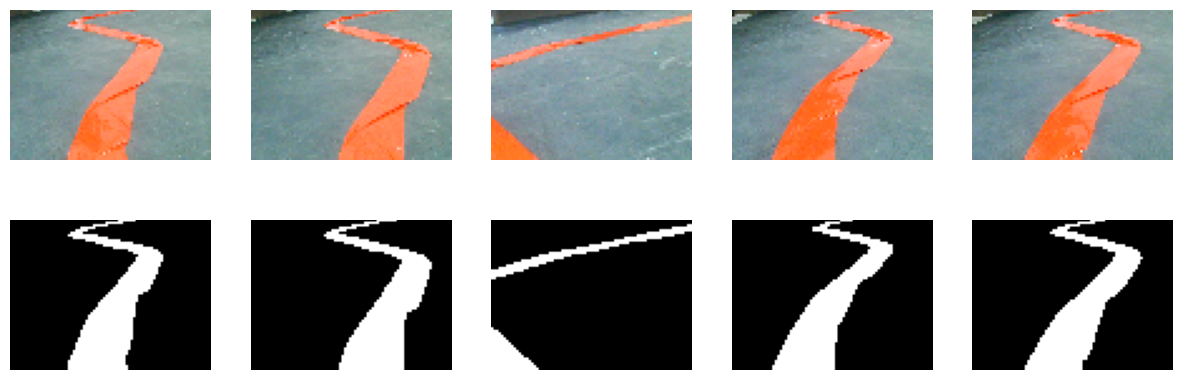

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    img = all_images[i]
    axs[0][i].axis('off')
    axs[0][i].imshow(img)

    img = all_segments[i]
    axs[1][i].axis('off')
    axs[1][i].imshow(img)
plt.show()

# Create datasets

In [ ]:
def rgb_to_labels(image_list: list) -> np.ndarray:
    """
    Create label arrays from rgb image.
    """

    result = []

    for d in image_list:
        sample = np.array(d)
        y = np.zeros((img_h, img_w, 1), dtype='uint8')

        for i, cl in enumerate(class_labels):
            y[np.where(np.all(sample == class_labels[i], axis=-1))] = i

        result.append(y)

    return np.array(result)

In [ ]:
def labels_to_rgb(image_list):
    """
    Create 3 channel arrays from label arrays.
    """

    result = []

    for y in image_list:
        temp = np.zeros((img_h, img_w, 3), dtype='uint8')

        for i, cl in enumerate(class_labels):
            temp[np.where(np.all(y==i, axis=-1))] = class_labels[i]

        result.append(temp)

    return np.array(result)

In [ ]:
def label_to_rgb(image):
  """
    Create rgb from label array.
  """

  result = np.zeros((img_h, img_w, 3), dtype='uint8')
  for i, cl in enumerate(class_labels):
    result[np.where(np.all(image==i, axis=-1))] = class_labels[i]
  return np.array(result)


In [ ]:
x_all = []

for img in all_images:
    x = image.img_to_array(img)
    x_all.append(x)

x_all = np.array(x_all)
print(x_all.shape)

(400, 60, 80, 3)


In [ ]:
# Normalize data for better results from network
# Original data
x_all /= 255.

In [ ]:
print(x_all[0][0][0])

[0.24705882 0.25882354 0.18431373]


In [ ]:
# Segmented data
y_all = rgb_to_labels(all_segments)

print(y_all.shape)

(400, 60, 80, 1)


In [ ]:
# Split it into train and validation
x_train,x_val,y_train,y_val = train_test_split(x_all, y_all, test_size = 0.15, shuffle = True)

print(f"size of x_train {x_train.shape}")
print(f"size of x_val {x_val.shape}")
print(f"size of y_train {y_train.shape}")
print(f"size of y_val {y_val.shape}")

size of x_train (340, 60, 80, 3)
size of x_val (60, 60, 80, 3)
size of y_train (340, 60, 80, 1)
size of y_val (60, 60, 80, 1)


# Unet light

Tried some architecture with different parameters and stopted at this one. It gives very nice result with not so complicated and heavy architecture. Decreasing the learning rate also make it worse and not better.

In [ ]:
# We have two classes in segmentation (black, white pixels)
class_count = 2
input_shape = (img_h, img_w, 3)

In [ ]:
# Create the architecture

img_input = Input(input_shape)

# Block 1
x = Conv2D(32, (3, 3), padding='same', name='B1_conv1')(img_input)
x = Activation('relu')(x)

x = Conv2D(32, (3, 3), padding='same', name='B1_conv2')(x)
block_1_out = Activation('relu')(x)

x = MaxPooling2D(2)(block_1_out)


# Block 2
x = Conv2D(64, (3, 3), padding='same', name='B2_conv1')(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), padding='same', name='B2_conv2')(x)
block_2_out = Activation('relu')(x)

x = MaxPooling2D(2)(block_2_out)


# BottleNeck
x = Conv2D(128, (3, 3), padding='same', name='bottlenec_conv1')(x)
x = Activation('relu')(x)

x = Conv2D(128, (3, 3), padding='same', name='bottlenec_conv2')(x)
bottleneck_out = Activation('relu')(x)


# UP 1
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(bottleneck_out)
x = Activation('relu')(x)

x = concatenate([x, block_2_out])

x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)


# UP 2
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
x = Activation('relu')(x)

x = concatenate([x, block_1_out])

x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)


x = Conv2D(class_count,(3,3), activation='softmax', padding='same')(x)

model = Model(img_input, x)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 80, 3)]  0           []                               
                                                                                                  
 B1_conv1 (Conv2D)              (None, 60, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 60, 80, 32)   0           ['B1_conv1[0][0]']               
                                                                                                  
 B1_conv2 (Conv2D)              (None, 60, 80, 32)   9248        ['activation[0][0]']             
                                                                                              

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=20,
                    validation_data = (x_val,y_val))

Epoch 1/50
17/17 [==============================] - 15s 52ms/step - loss: 0.6881 - sparse_categorical_accuracy: 0.5983 - val_loss: 0.6619 - val_sparse_categorical_accuracy: 0.9329
Epoch 2/50
17/17 [==============================] - 0s 29ms/step - loss: 0.6318 - sparse_categorical_accuracy: 0.9343 - val_loss: 0.5722 - val_sparse_categorical_accuracy: 0.9435
Epoch 3/50
17/17 [==============================] - 0s 28ms/step - loss: 0.4245 - sparse_categorical_accuracy: 0.9061 - val_loss: 0.2339 - val_sparse_categorical_accuracy: 0.9087
Epoch 4/50
17/17 [==============================] - 0s 28ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.1121 - val_sparse_categorical_accuracy: 0.9641
Epoch 5/50
17/17 [==============================] - 0s 26ms/step - loss: 0.1131 - sparse_categorical_accuracy: 0.9612 - val_loss: 0.0914 - val_sparse_categorical_accuracy: 0.9717
Epoch 6/50
17/17 [==============================] - 0s 29ms/step - loss: 0.0929 - sparse_categorical_acc

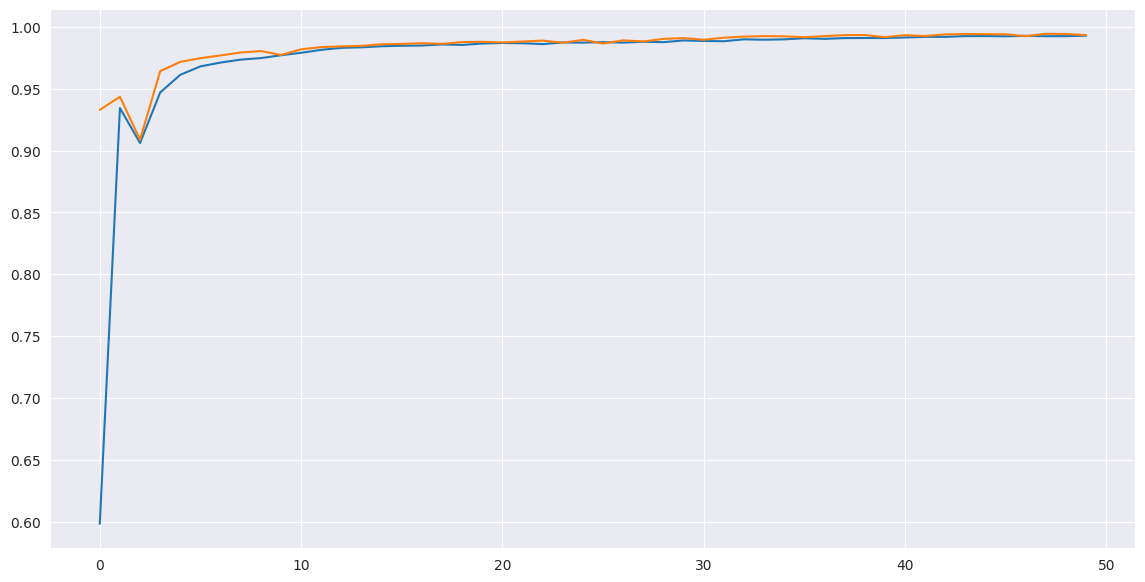

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

# Checking the results

In [ ]:
def process_images(model,
                   count=1,
                   indexes=None,
                   ):

    if indexes is None:
        indexes = np.random.randint(0, len(x_val), count)
    else:
        count = len(indexes)

    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)
    orig = labels_to_rgb(predict[..., None])
    print(type(predict))
    print(predict.shape)

    fig, axs = plt.subplots(3, count, figsize=(25, 10))

    for i in range(count):
        axs[0, 0].set_title('Results of the model:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        axs[1, 0].set_title('Original segmented pictures')
        axs[1, i].imshow(label_to_rgb(y_val[indexes[i]]))
        axs[1 ,i].axis('off')

        axs[2, 0].set_title('Original pictures')
        axs[2, i].imshow((x_val[indexes[i]] * 255.).astype('uint8'))
        axs[2 ,i].axis('off')

    plt.show()

1/1 [==============================] - 0s 20ms/step
<class 'numpy.ndarray'>
(5, 60, 80)


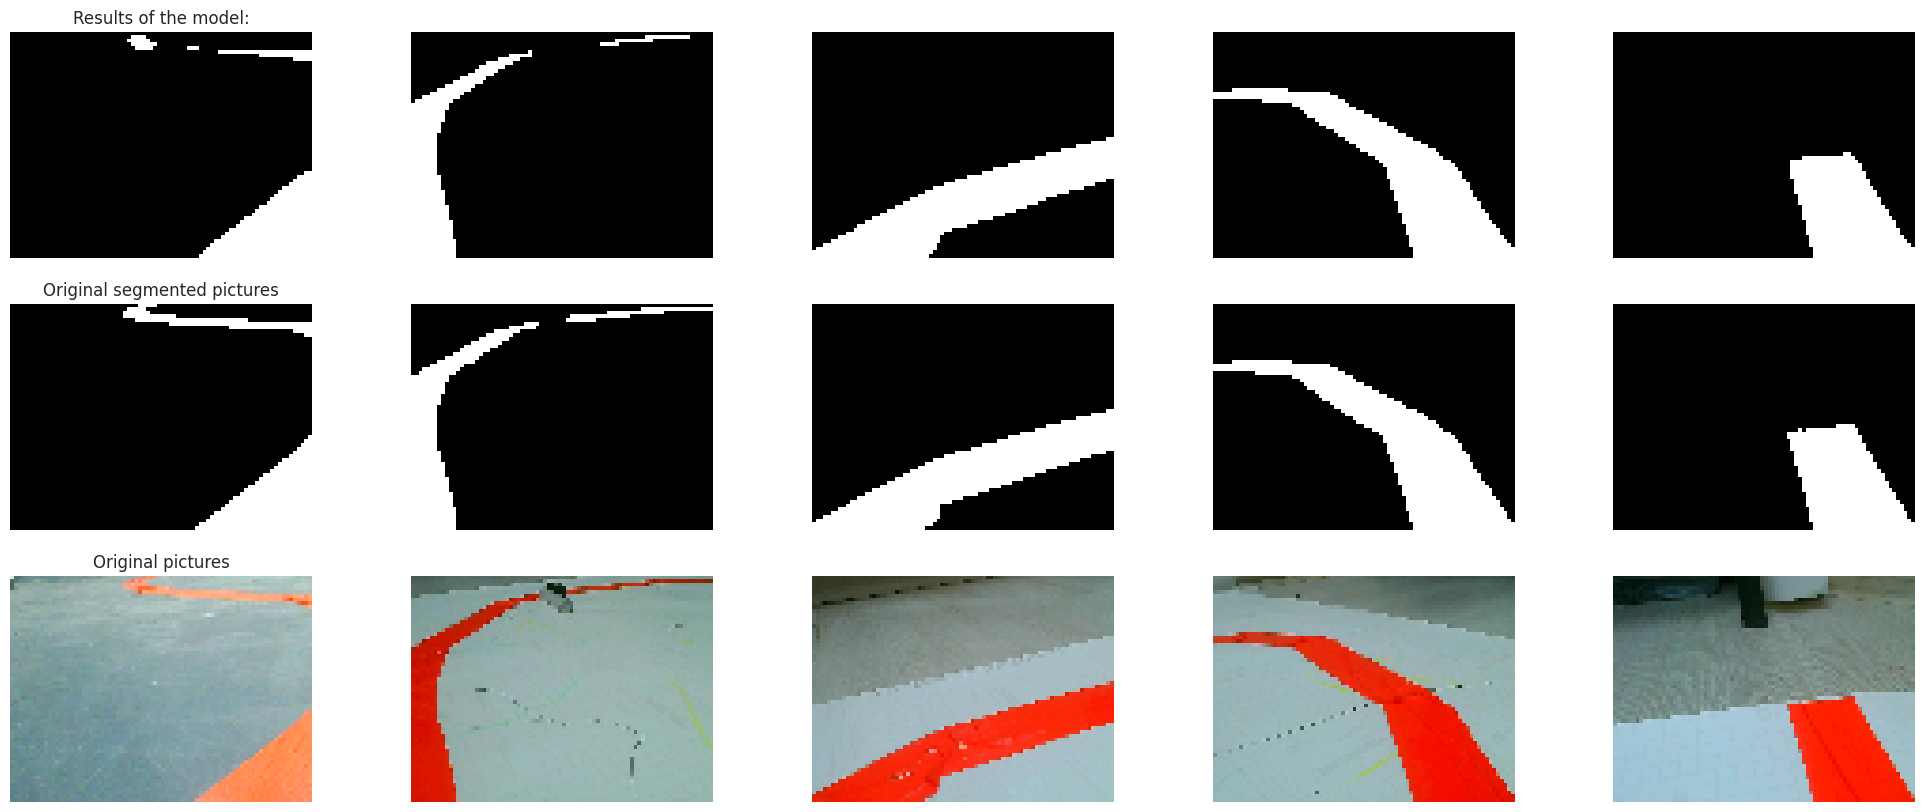

In [ ]:
process_images(model, 5)

# Pictures what NN hasn't seen yet

In [ ]:
# Unzip test package of images (originals)
!unzip -qo /content/gdrive/MyDrive/Colab_Notebooks/Diplom/data_all/x_test.zip

In [ ]:
# Unzip test package of images (segmented)
!unzip -qo /content/gdrive/MyDrive/Colab_Notebooks/Diplom/data_all/y_test.zip

In [ ]:
x_test_images = load_imageset('x_test')

y_test_images = load_imageset('y_test')

All imageset is loaded. Time of loading: 0.04 с
Number of pictures: 17
All imageset is loaded. Time of loading: 0.01 с
Number of pictures: 17


In [ ]:
x_test = []

for img in x_test_images:
    x = image.img_to_array(img)
    x_test.append(x)

x_test = np.array(x_test)
print(x_test.shape)

(17, 60, 80, 3)


In [ ]:
y_test = []

for img in y_test_images:
    y = image.img_to_array(img)
    y_test.append(y)

y_test = np.array(y_test)
print(y_test.shape)

(17, 60, 80, 3)


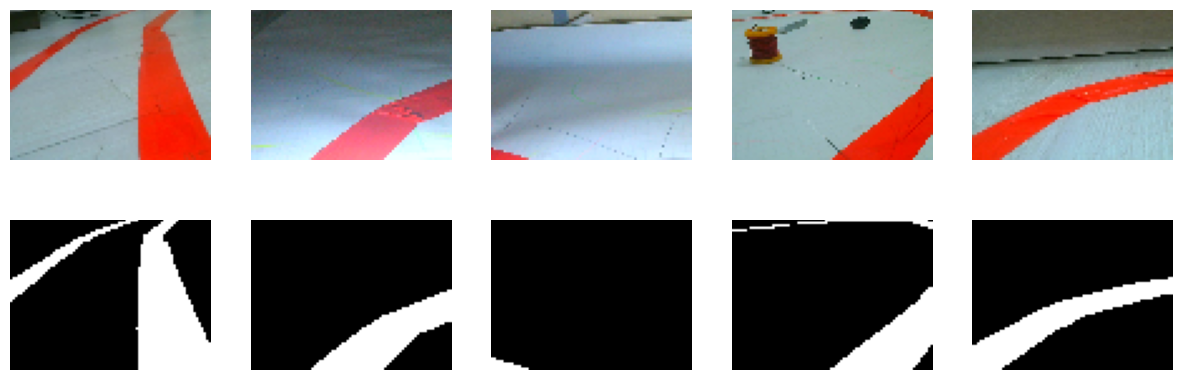

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    img = x_test[i].astype('uint8')
    axs[0][i].axis('off')
    axs[0][i].imshow(img)

    img = y_test[i].astype('uint8')
    axs[1][i].axis('off')
    axs[1][i].imshow(img)
plt.show()

In [ ]:
# Normalize data
x_test /= 255.

1/1 [==============================] - 0s 23ms/step


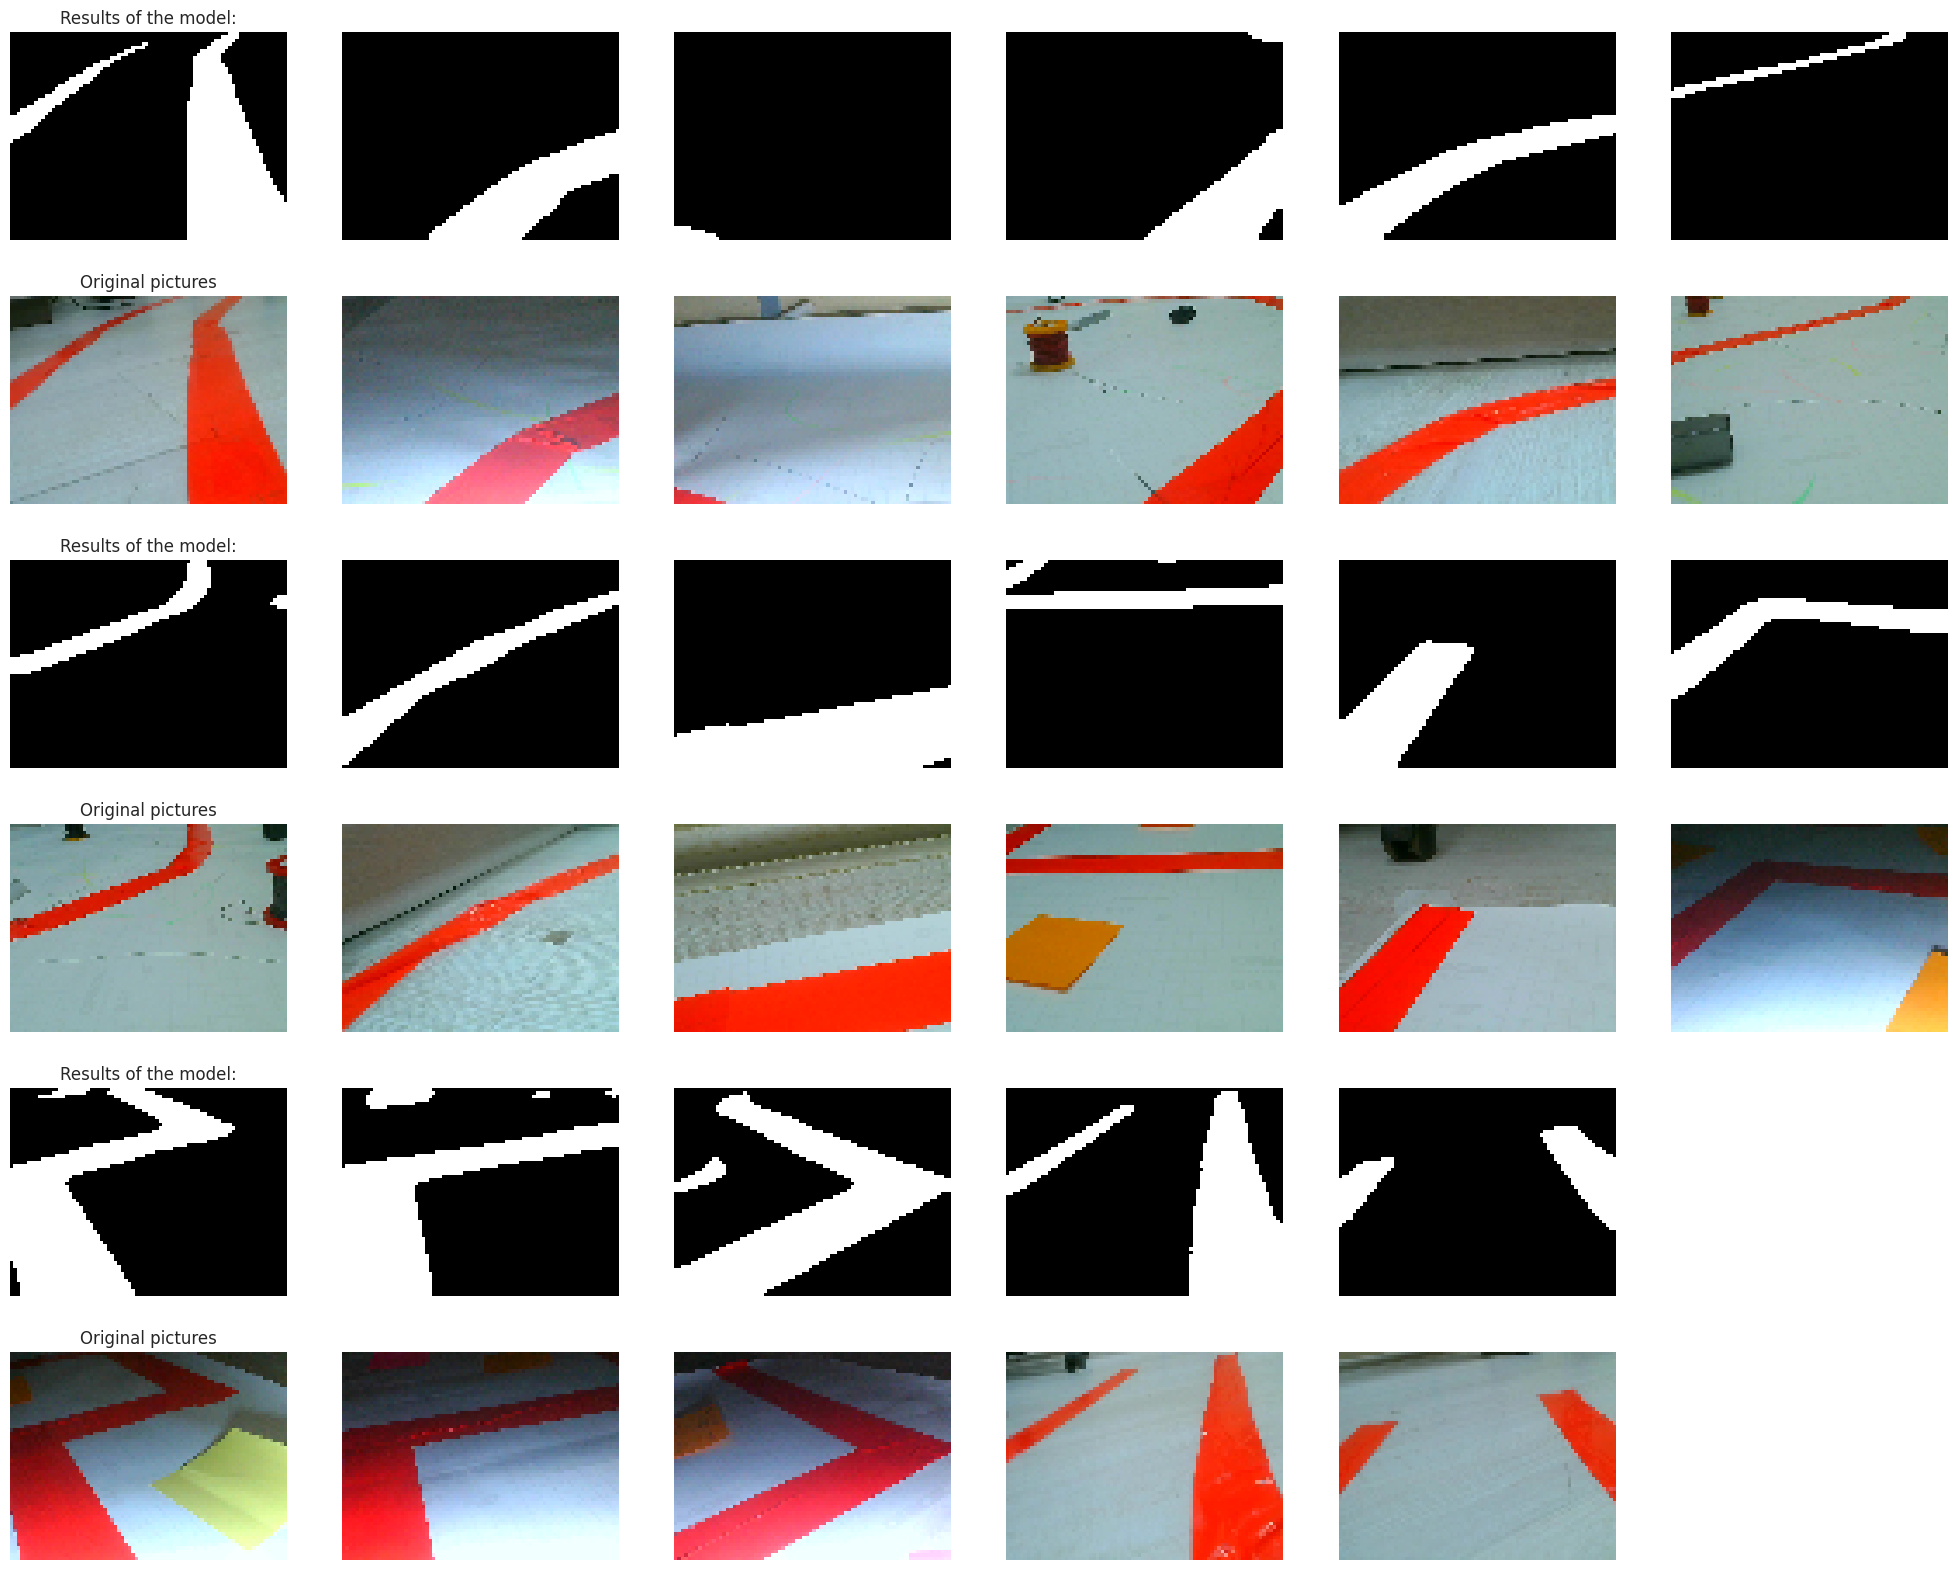

In [ ]:
predict = np.argmax(model.predict(x_test), axis=-1)
test_segments = labels_to_rgb(predict[..., None])

fig, axs = plt.subplots(6, 6, figsize=(25, 20))

for i in range(6):
    axs[0, 0].set_title('Results of the model:')
    axs[0, i].imshow(test_segments[i])
    axs[0, i].axis('off')

    axs[1, 0].set_title('Original pictures')
    axs[1, i].imshow((x_test[i] * 255.).astype('uint8'))
    axs[1 ,i].axis('off')

    axs[2, 0].set_title('Results of the model:')
    axs[2, i].imshow(test_segments[6+i])
    axs[2, i].axis('off')

    axs[3, 0].set_title('Original pictures')
    axs[3, i].imshow((x_test[6+i] * 255.).astype('uint8'))
    axs[3 ,i].axis('off')

    axs[4, 0].set_title('Results of the model:')
    if 12+i < 17: axs[4, i].imshow(test_segments[12+i])
    axs[4, i].axis('off')

    axs[5, 0].set_title('Original pictures')
    if 12+i < 17: axs[5, i].imshow((x_test[12+i] * 255.).astype('uint8'))
    axs[5 ,i].axis('off')

plt.show()

# Saving the model for further use

In [ ]:
model.save('/content/gdrive/MyDrive/Colab_Notebooks/Diplom/model_unet_light_new.h5')

In [ ]:
my_model = load_model('/content/gdrive/MyDrive/Colab_Notebooks/Diplom/model_unet_light_new.h5')

# Show the model architecture
# my_model.summary()

# U-net Batchnorm

In [ ]:
img_input = Input(input_shape)

# Block 1
x = Conv2D(32, (3, 3), padding='same', name='B1_conv1')(img_input)
x = Activation('relu')(x)

x = BatchNormalization()(x)

x = Conv2D(32, (3, 3), padding='same', name='B1_conv2')(x)
block_1_out = Activation('relu')(x)

x = MaxPooling2D(2)(block_1_out)



# Block 2
x = Conv2D(64, (3, 3), padding='same', name='B2_conv1')(x)
x = Activation('relu')(x)

x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), padding='same', name='B2_conv2')(x)
block_2_out = Activation('relu')(x)

x = MaxPooling2D(2)(block_2_out)



# BottleNeck
x = Conv2D(128, (3, 3), padding='same', name='bottlenec_conv1')(x)
x = Activation('relu')(x)

x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same', name='bottlenec_conv2')(x)
bottleneck_out = Activation('relu')(x)



# UP 1
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(bottleneck_out)
x = Activation('relu')(x)

x = concatenate([x, block_2_out])

x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)

x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)



# UP 2
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
x = Activation('relu')(x)

x = concatenate([x, block_1_out])

x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)

x = BatchNormalization()(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)


x = Conv2D(class_count,(3,3), activation='softmax', padding='same')(x)

model = Model(img_input, x)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60, 80, 3)]  0           []                               
                                                                                                  
 B1_conv1 (Conv2D)              (None, 60, 80, 32)   896         ['input_2[0][0]']                
                                                                                                  
 activation_12 (Activation)     (None, 60, 80, 32)   0           ['B1_conv1[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 60, 80, 32)  128         ['activation_12[0][0]']          
 alization)                                                                                 

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=20,
                    validation_data = (x_val,y_val),
                    shuffle = True)

Epoch 1/50
17/17 [==============================] - 7s 52ms/step - loss: 0.6724 - sparse_categorical_accuracy: 0.5846 - val_loss: 0.6611 - val_sparse_categorical_accuracy: 0.9402
Epoch 2/50
17/17 [==============================] - 0s 28ms/step - loss: 0.3254 - sparse_categorical_accuracy: 0.9118 - val_loss: 0.6291 - val_sparse_categorical_accuracy: 0.9430
Epoch 3/50
17/17 [==============================] - 1s 31ms/step - loss: 0.1814 - sparse_categorical_accuracy: 0.9631 - val_loss: 0.5777 - val_sparse_categorical_accuracy: 0.8764
Epoch 4/50
17/17 [==============================] - 0s 28ms/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9742 - val_loss: 0.5156 - val_sparse_categorical_accuracy: 0.8399
Epoch 5/50
17/17 [==============================] - 1s 30ms/step - loss: 0.0861 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.4670 - val_sparse_categorical_accuracy: 0.8351
Epoch 6/50
17/17 [==============================] - 1s 31ms/step - loss: 0.0681 - sparse_categorical_accu

# Checking the results

1/1 [==============================] - 0s 198ms/step


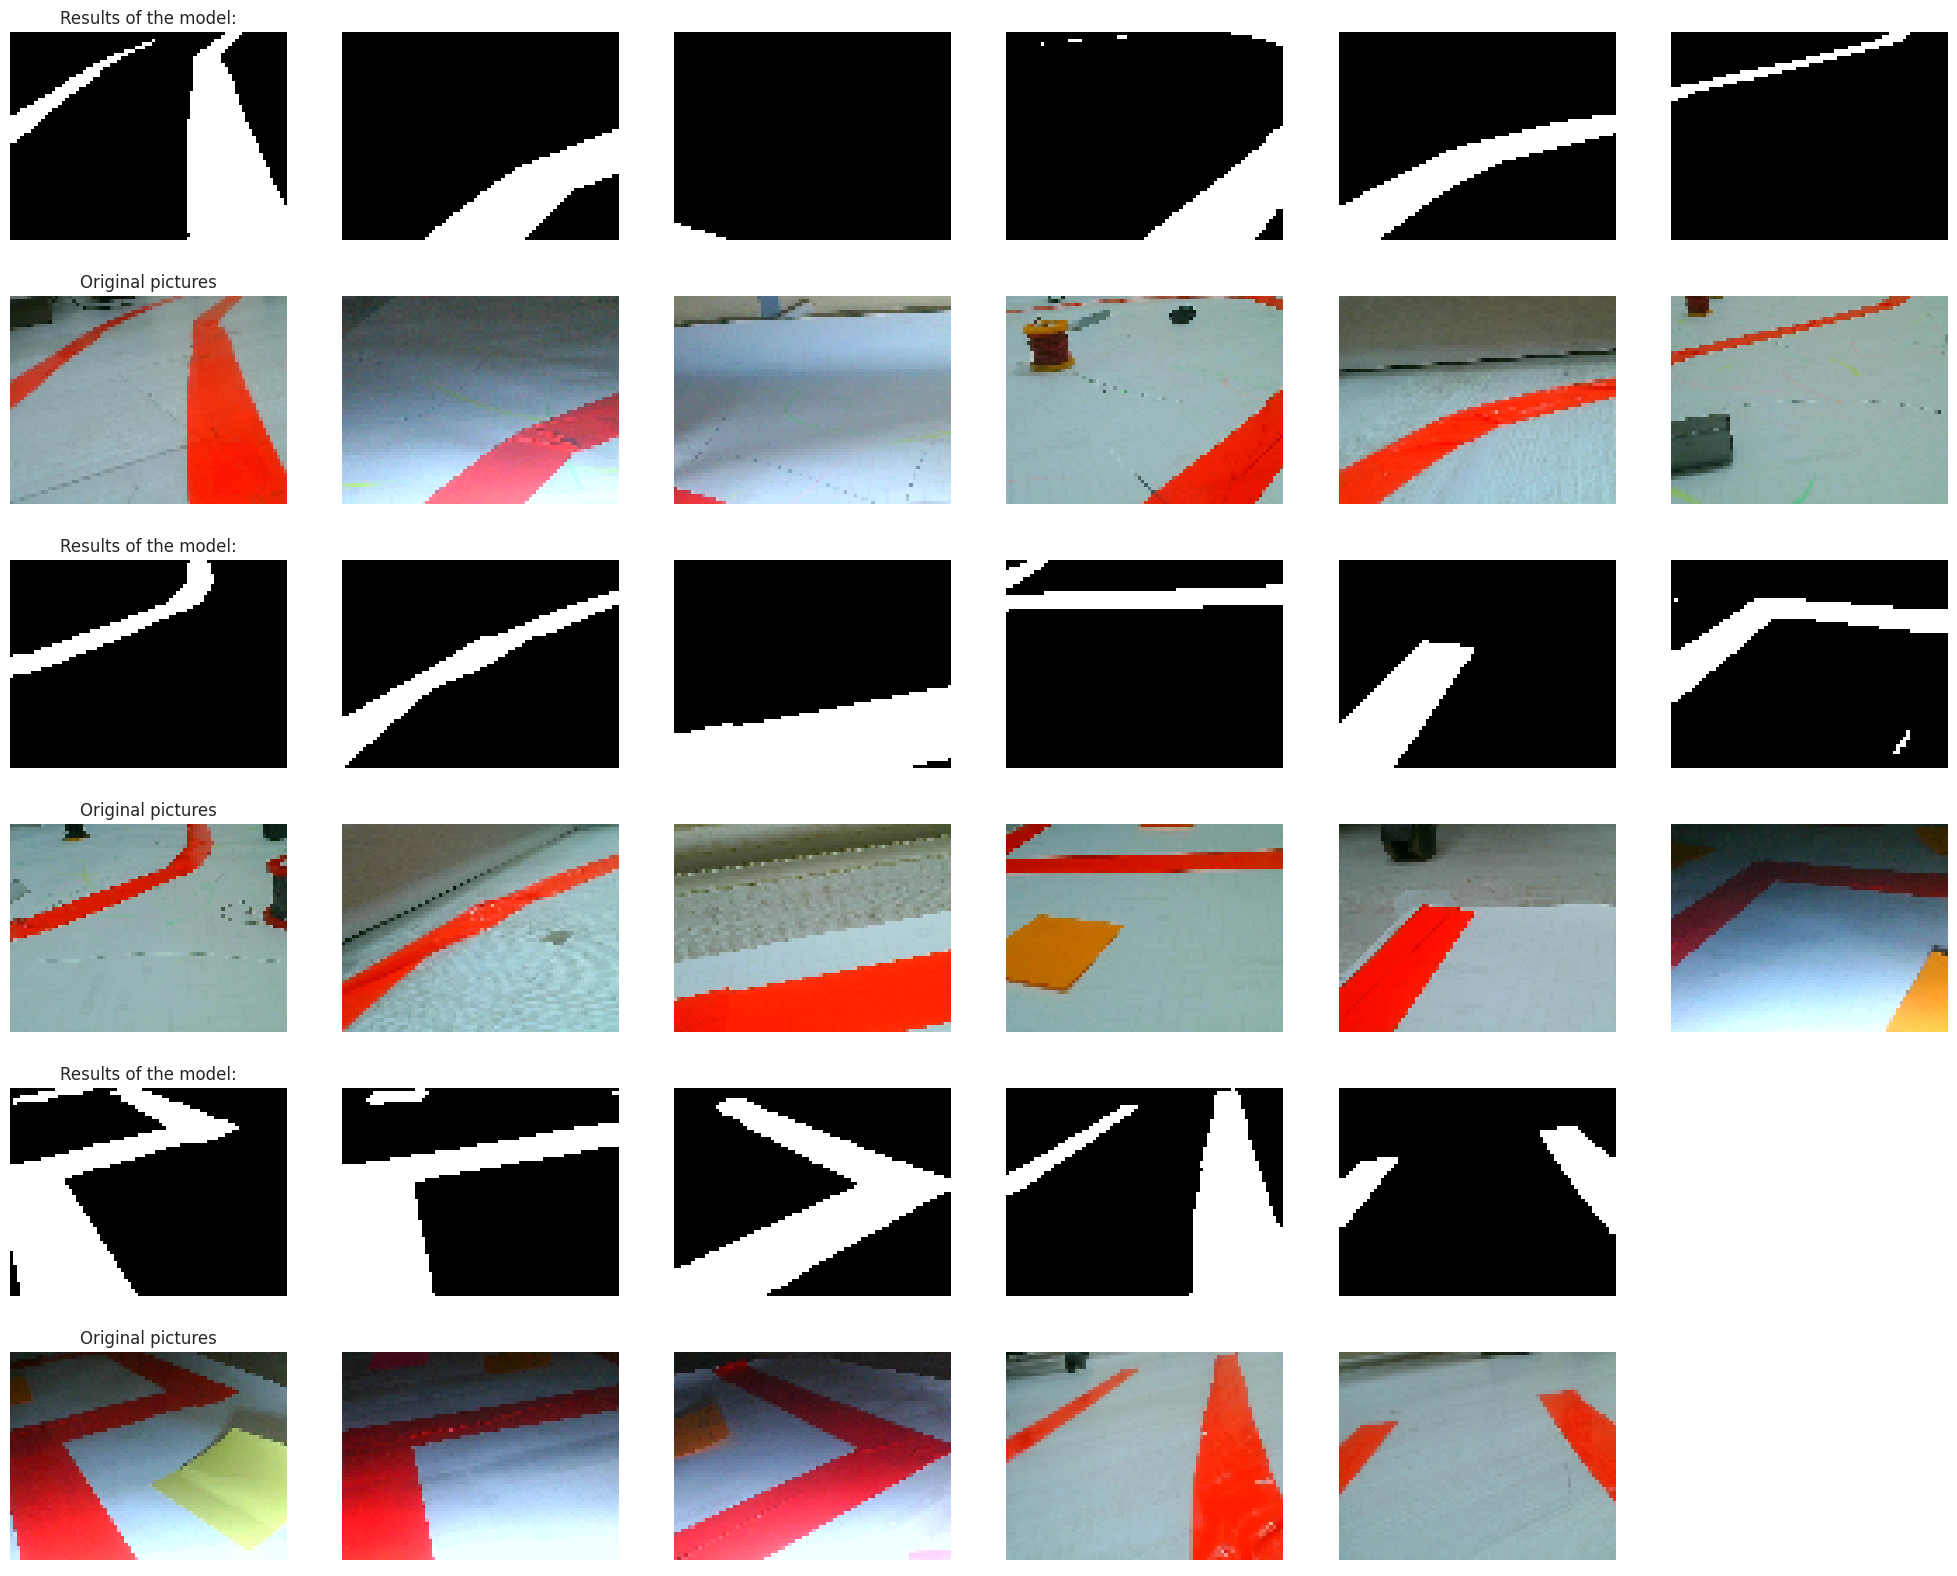

In [ ]:
predict = np.argmax(model.predict(x_test), axis=-1)
test_segments = labels_to_rgb(predict[..., None])

fig, axs = plt.subplots(6, 6, figsize=(25, 20))

for i in range(6):
    axs[0, 0].set_title('Results of the model:')
    axs[0, i].imshow(test_segments[i])
    axs[0, i].axis('off')

    axs[1, 0].set_title('Original pictures')
    axs[1, i].imshow((x_test[i] * 255.).astype('uint8'))
    axs[1 ,i].axis('off')

    axs[2, 0].set_title('Results of the model:')
    axs[2, i].imshow(test_segments[6+i])
    axs[2, i].axis('off')

    axs[3, 0].set_title('Original pictures')
    axs[3, i].imshow((x_test[6+i] * 255.).astype('uint8'))
    axs[3 ,i].axis('off')

    axs[4, 0].set_title('Results of the model:')
    if 12+i < 17: axs[4, i].imshow(test_segments[12+i])
    axs[4, i].axis('off')

    axs[5, 0].set_title('Original pictures')
    if 12+i < 17: axs[5, i].imshow((x_test[12+i] * 255.).astype('uint8'))
    axs[5 ,i].axis('off')

plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/Colab_Notebooks/Diplom/model_unet_light_new_better.h5')